In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import heapq
import os
from decimal import Decimal
np.set_printoptions(threshold=np.nan) 
home_path = os.getcwd().replace('BC1/notebooks','')
import cPickle as pickle
import pandas as pd
from scipy.signal import find_peaks
import json
import matplotlib.animation as animation
import copy
import matplotlib as mpl
from skimage.measure import compare_ssim as ssim

In [2]:
with open("separate_BC.json", "r") as read_file:
    json_file = json.load(read_file)
name_json = json_file["file_name"]
split = name_json.split('.')
run_number = split[1][2:7]

In [3]:

single_anode_channel = int(json_file["single_anode_channel"])
number_tubes_json = len(json_file["tubes"])
input_name_json = json_file["file_name"]

In [4]:
def find_tubes(signal, percentage, number_tubes):
    """
    Function to find the first and last indexes of each
    tube inside the cell. In other words, this function
    get the signal when the cesium capsule is inside
    the cell.
    Parameters:
    ----------
    signal : array
        Array with signal profile from Cesium Scan.
    percentage : float
        Constant number of the percentage to cut the
        ADC Counts axis of the signal, in order to
        find the tubes in the cell.
    number_tubes : int
        Expected number of tubes inside the cell.
    Returns:
    -------
    indexes : list
        List with tuples containing the first and
        last indexes of each tube found.
    """
    # get peak indexes
    height = np.max(signal) * percentage
    peak_idx, _ = find_peaks(signal, height=height)

    # distance between peaks
    peak_dist = np.diff(peak_idx)

    # positional argument
    pos = np.array([i+1 for i, dist in enumerate(peak_dist) if dist >= 100])
    pos = np.insert(pos, 0, 0)
    pos = np.insert(pos, len(pos), len(peak_dist)+1)

    # loop througout all the tubes
    indexes = []
    for tube in range(number_tubes):
        # get the peaks indexes for each tube
        peaks_per_tube = peak_idx[pos[tube]:pos[tube+1]]

        # get mean distance between peaks/periods
        mean_period = np.mean(np.diff(peaks_per_tube))

        # get first and last indexes of this tube
        first = int(peaks_per_tube[0] - (6*mean_period))
        last = int(peaks_per_tube[-1] + (6*mean_period))
        indexes.append((first, last))

    return indexes


In [5]:
#opening the file
dictionary_path = home_path+'processed_data/Dados BC1/'
file = open(dictionary_path+input_name_json+'.pkl','rb')
cesium_scan = pickle.load(file)

single_data = cesium_scan['data'][:, single_anode_channel]

#Path to the channel reading mapping file
map_path = home_path+'processed_data/Dados BC1/mapping.txt'

In [6]:
# Find the tubes inside the cell using the
# peaks information of the single anode PMT
tubes_idx = find_tubes(single_data,percentage=0.6,number_tubes=number_tubes_json)

In [7]:
#Phill's function(No change)
def create_tensor(data, map_file):
    """
    Create tensor from signal profile of the MA-PMT.
    In other words, stack snapshots of the MA-PMT image
    for each time interval.
    Parameters:
    ----------
    data : 2D array
        rows - samples/measurements
        columns - channels/features
    map_file : str
        Complete path of the mapping file.
    Returns:
    -------
    data_tensor : 3D array
        Tensorial format of the data.
    """
    n_samples = data.shape[0]
    data_tensor = np.zeros([8, 8, n_samples])

    # get mapping for image pixels
    pixel_map = np.loadtxt(map_file)

    # nested loop for the grid of pixels
    for i in range(8):
        for j in range(8):
            if pixel_map[i, j] == 0:
                data_tensor[i, j, :] = 1e-8
            else:
                channel = int(pixel_map[i, j]-1)
                data_tensor[i, j, :] = data[:, channel]

    return data_tensor


In [8]:
#Phill's function(No change)
def check_scan_direction(file_name, verbose=True):
    """
    Function to check if the cesium scan was made Forward or Backward
    and if the cell is on the positive (A) or negative (C) side of
    the pseudo-rapidity.
    This is done by splitting the string, containing the name of the
    ROOT data, and retrieving information by the scan coded on the
    file name.
    Parameters:
    ----------
    file_name : string
        Name of the cesium scan ROOT file. Encoded as:
            - A1.CS99999F.LBA66
    verbose : boolean (optional)
        Verbose variable to print information in the screen.
        - default - True
    Returns:
    -------
    scan_info : dict
        Dictionary with useful informations about the cesium scan.
    """
    # split the file name and extract informations
    split = file_name.split('.')
    cell = split[0]
    run_number = split[1][2:7]
    direction = split[1][-1]
    barrel = split[2][:2]
    module = split[2][3:]
    side = split[2][2]
    connector = split[3]

    # print information
    if verbose:
        print('\n>> Data Characteristics <<')
        print('  - Run: %s' % run_number)
        print('  - Cell: %s' % cell)
        print('  - Connector: %s' % connector)
        print('  - Barrel: %s' % barrel)
        print('  - Module: %s' % module)
        print('  - Side: %s' % side)
        print('  - Scan direction: %s' % direction)

    # dictionary holding the direction constants
    direction_const = {'F': 1, 'B': -1}

    # auxiliary constants for each tube
    if barrel == 'LB':
        tubes_const = np.asarray([-1, 1, -1, 1, -1, 1, -1, 1, -1, 1, -1])
        # the indexes are in the physical scale
        tubes_idx = {'A': np.asarray([0, 1, 2]),
                     'BC': np.asarray([3, 4, 5, 6, 7, 8]),
                     'D': np.asarray([9, 10])}
    elif barrel == 'EB':
        print('Direction of Extended Barrel (EB) not implemented yet!')
        sys.exit()
    else:
        print('Not a valid name for TileCal barrel.')
        print('Possible names are: LB and EB')
        sys.exit()

    # check cells and barrels
    cell_digit = filter(lambda x: x.isalpha(), cell)
    tube_direction = tubes_const[tubes_idx[cell_digit]] \
    * direction_const[direction]

    if direction == 'F':
        tube_order = np.flip(tubes_idx[cell_digit], 0) + 1
    elif direction == 'B':
        tube_order = tubes_idx[cell_digit] + 1
    else:
        print('Not a valid scan direction.')
        print('Possible values are: F and B')
        sys.exit()

    # add to results
    scan_info = {'tube_order': tube_order,
                 'tube_direction': tube_direction,
                 'n_tubes': len(tubes_idx[cell_digit])}

    return scan_info

In [9]:
# check scan direction and cell side
scan_info = check_scan_direction(input_name_json)


>> Data Characteristics <<
  - Run: 10706
  - Cell: BC1
  - Connector: FOCON
  - Barrel: LB
  - Module: 66
  - Side: A
  - Scan direction: F


In [10]:
def separate_cell(single_anode_channel,scan_info):
    """
    Function to separate the data from the cesium scan,
    separating them into cells B and C.
    
    Parameters:
    ----------
    single_anode_channel : int
    Position of the channel "Single Anode"  
    
    scan_info : function 
         Function results {"scan_info"}
    Returns:
    -------
    separated_cell : dict
        Dictionary with separation between B and C cells from cesium scanning.
    """
    
    separated_cell={}
    results = {}
    index = []
    results['single_anode'] = single_anode_channel 
    check = [0,0,0,3,3,3]
    for tube, idx in enumerate(tubes_idx):

        results.setdefault('data',[]).append(cesium_scan['data'][idx[0]:idx[1], :])
        # getting only a few indexes
        if ((tube - check[tube])==0):
            index.append(idx[0])
        if ((tube - check[tube])==2):
            index.append(idx[1])

            results.setdefault('trigger',[]).append(cesium_scan['trigger'][index[0]:index[1]])
            results.setdefault('timesec',[]).append(cesium_scan['timesec'][index[0]:index[1]])
            results.setdefault('timemksec',[]).append(cesium_scan['timemksec'][index[0]:index[1]])
            index = []


         # check if is needed to inverse the data
        if scan_info['tube_direction'][tube] == -1:
            #count up to 2 twice(tube - check[tube])
            results['data'][tube - check[tube]] = np.flip(results['data'][tube - check[tube]], axis=0)

         # create tensor images       
        results.setdefault('tensor',[]).append(create_tensor(results['data'][tube - check[tube]], map_path))

        if (tube == 2):
            #deep copy will copy all contents by value.
            separated_cell["DataB"] = copy.deepcopy(results)
            #clean dictionary
            results = {}
        if (tube == 5):
            separated_cell["DataC"] = copy.deepcopy(results)
            results = {}
    return separated_cell

In [11]:
results = separate_cell(single_anode_channel,scan_info)

In [14]:
pixel_map = np.loadtxt(map_path)
# nested loop for the grid of pixels
for i in range(8):
    for j in range(8):
        if pixel_map[i, j] != 0:
            n=int(pixel_map[i,j]-1)
          
            
            
            plt.figure(figsize=(15,15))
            plt.suptitle("Channels BC1 Pixel "+str(n+1))
            
            plt.subplot(331)
            plt.plot(results["DataB"]["data"][0][:,n])
            plt.plot(results["DataB"]["data"][0][:,2])
            plt.title("Data B Tube 4")
            
            plt.subplot(332)
            plt.plot(results["DataB"]["data"][1][:,n])
            plt.plot(results["DataB"]["data"][1][:,2])
            plt.title("Data B Tube 5")
            
            plt.subplot(333)
            plt.plot(results["DataB"]["data"][2][:,n])
            plt.plot(results["DataB"]["data"][2][:,2])
            plt.title("Data B Tube 6")
            

            plt.subplot(334)
            plt.plot(results["DataC"]["data"][0][:,n])
            plt.plot(results["DataC"]["data"][0][:,2])
            plt.title("Data C Tube 7")
            
            plt.subplot(335)
            plt.plot(results["DataC"]["data"][1][:,n])
            plt.plot(results["DataC"]["data"][1][:,2])
            plt.title("Data C Tube 8")

            plt.subplot(336)
            plt.plot(results["DataC"]["data"][2][:,n])
            plt.plot(results["DataC"]["data"][2][:,2])
            plt.title("Data C Tube 9")
            
            plt.savefig(home_path+"BC1/analysis/CS10706F/Channels/channel"+str(int(pixel_map[i,j]))+".png", bbox_inches='tight')
            plt.clf()
            


/home/creison/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

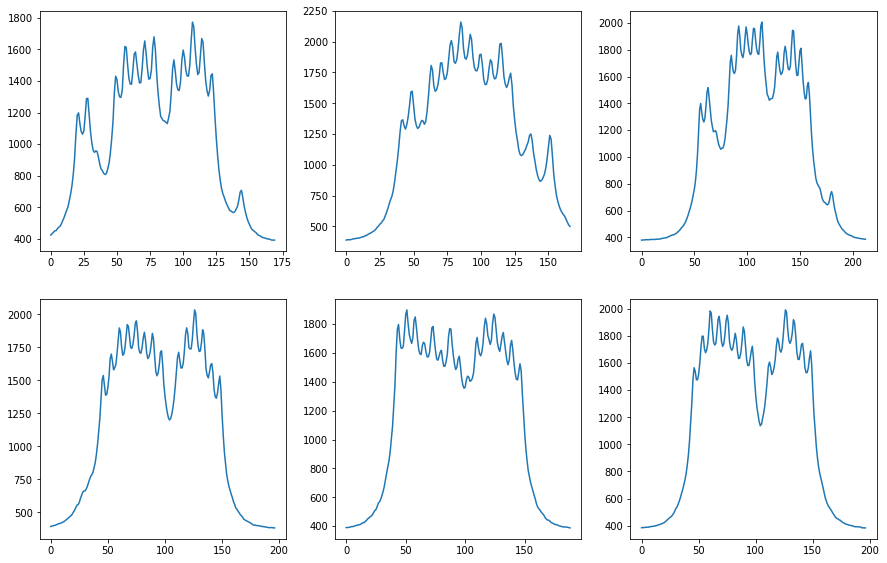

In [15]:
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.plot(results["DataB"]["data"][0][:,2])

plt.subplot(332)
plt.plot(results["DataB"]["data"][1][:,2])

plt.subplot(333)
plt.plot(results["DataB"]["data"][2][:,2])


plt.subplot(334)
plt.plot(results["DataC"]["data"][0][:,2])

plt.subplot(335)
plt.plot(results["DataC"]["data"][1][:,2])

plt.subplot(336)
plt.plot(results["DataC"]["data"][2][:,2])
plt.show()

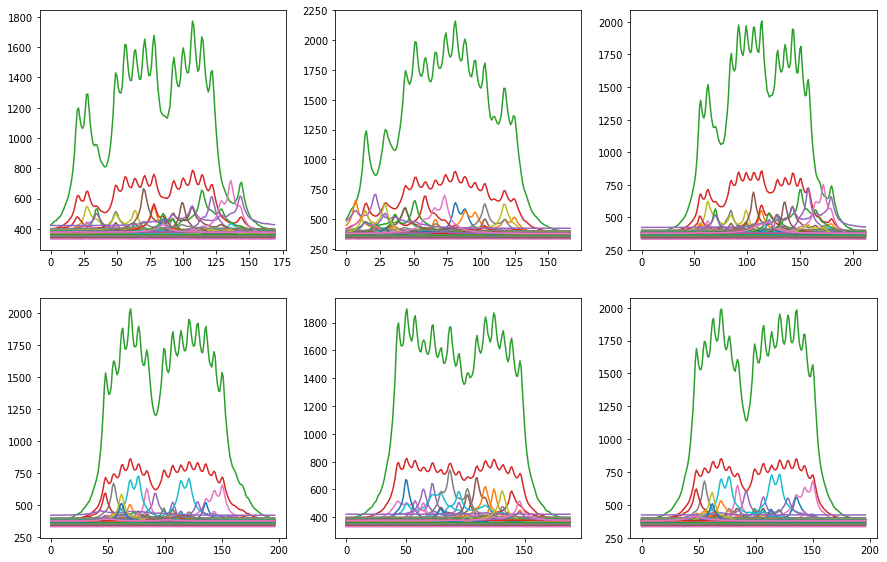

In [16]:
plt.figure(figsize=(15,15))

plt.subplot(331)
plt.plot(cesium_scan['data'][tubes_idx[0][0]:tubes_idx[0][1]])

plt.subplot(332)
plt.plot(cesium_scan['data'][tubes_idx[1][0]:tubes_idx[1][1]])


plt.subplot(333)
plt.plot(cesium_scan['data'][tubes_idx[2][0]:tubes_idx[2][1]])


plt.subplot(334)
plt.plot(cesium_scan['data'][tubes_idx[3][0]:tubes_idx[3][1]])

plt.subplot(335)
plt.plot(cesium_scan['data'][tubes_idx[4][0]:tubes_idx[4][1]])

plt.subplot(336)
plt.plot(cesium_scan['data'][tubes_idx[5][0]:tubes_idx[5][1]])
plt.show()

In [17]:
pickle.dump(results,open(dictionary_path+input_name_json+"_separate.pkl", "wb"))


In [18]:
def min_max_value(results):
    max_value = None
    min_value = (not None)
    
    cells_name = results.keys()
    for name in cells_name:
        for n_tubes in range(3):
            if (max_value < results[name]["tensor"][n_tubes].max() ):
                max_value = results[name]["tensor"][n_tubes].max()
            if (min_value > results[name]["tensor"][n_tubes].min() ):
                min_value = results[name]["tensor"][n_tubes].min()
    value = [min_value,max_value]
    return value 

In [19]:
min_max_value = min_max_value(results)

In [20]:
def med_value(results):
    max_value = None
    min_value = (not None)
    
    cells_name = results.keys()
    for name in cells_name:
        contador = 0;
        media = np.zeros(shape=(8,8))
        for n_tubes in range(3):
            for l in range(results[name]["tensor"][n_tubes].shape[2]):
                media += results[name]["tensor"][n_tubes][:,:,l]
                
            contador += results[name]["tensor"][n_tubes].shape[2]            
        media = media/contador
        
        if (max_value < media.max() ):
            max_value = media.max()
        if (min_value > media.min() ):
            min_value = media.min()
    
    value = [min_value,max_value]
    return value 

In [21]:
med_value = med_value(results)

In [29]:
def generate_images(results,name_json,min_max):
    """
        Private method creating a vector image in a chosen folder
        Only for create image
        
        Args:
        ----
        map_file (str): complete path to where the images will be generated

        Returns:
        Image
        -------
        
    """
    cells_name = results.keys()
    split = name_json.split('.')
    run_number = split[1][2:7]


        #Method to generate the images
    for name in cells_name:
 
        fig, ax = plt.subplots(figsize=(15,15))
        #create colorbar
        rm = plt.cm.ScalarMappable(cmap='YlGnBu',norm=plt.Normalize(vmin=min_max[0],vmax=min_max[1]))
        rm._A = []
        cb=plt.colorbar(rm)
        cb.ax.tick_params(labelsize=15)
        tick_locator = ticker.MaxNLocator(nbins=8)
        cb.locator = tick_locator
        cb.update_ticks()
        
        path= home_path+'BC1/analysis/CS'+run_number+'F/separate_cells_BC/'+name
        imagens = []
        for n_tubes in range(1):
            for l in range(results[name]["tensor"][n_tubes].shape[2]):
        
                
                #ma_pmt_image receives array from imported file after passing through "create image"
                ma_pmt_image = results[name]["tensor"][n_tubes][:,:,l]
                

                #Create the image
                im = ax.matshow(ma_pmt_image,cmap='YlGnBu' , vmin=min_max[0], vmax=min_max[1])
                X= str(l+1)

                
                #Sets image margins size
                plt.title("# Pixel Map Cell "+name[4]+" Tube "+ str(n_tubes+1) +" Image "+X , fontsize = 25)
                plt.xticks([])
                plt.yticks([])
                plt.xlabel("Pixels X",fontsize=20)
                plt.ylabel("Pixels Y",fontsize=20)
                
                
                imagens.append([im])
                #plt.savefig(path+'/Imagem_Tube_'+ str(n_tubes+1)+'_Image_'+X+'.png', bbox_inches='tight')
                

                
        plt.title("# Pixel Map Cell "+name[4] , fontsize = 25)
        
        animate = animation.ArtistAnimation(fig, imagens, interval=50, blit=True,repeat = False)
        
        path_video = path.replace(name,'')
        
        #animate.save(path_video+"/Video_Tube_"+name+".gif")        
        plt.clf()

        print name 


In [30]:
generate_images(results,input_name_json,min_max_value)

DataC
DataB


<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

In [31]:
def plot_max_value(results,name_json,min_max):

    cells_name=results.keys()
    lista = np.zeros(shape=(8,8))
    split = name_json.split('.')
    run_number = split[1][2:7]
    for name in cells_name:
        sum_list = np.zeros(shape=(8,8))
        path= home_path+'BC1/analysis/CS'+run_number+'F/separate_cells_BC/'+name
        for n_tubes in range(3):     
            for l in range(results[name]["tensor"][n_tubes].shape[2]):
                
                for i in range(8):
                    for j in range(8):
                        if (lista[i][j] < results[name]["tensor"][n_tubes][:,:,l][i][j]):
                            lista[i][j] = results[name]["tensor"][n_tubes][:,:,l][i][j]
            
          
            lista2 = (lista - min_max[0])/(min_max[1]-min_max[0])

            #Create the image
            fig, ax = plt.subplots(figsize=(15,15))
            #create colorbar
            rm = plt.cm.ScalarMappable(cmap='YlGnBu',norm=plt.Normalize(vmin=0,vmax=1))
            rm._A = []
            cb=plt.colorbar(rm)
            cb.ax.tick_params(labelsize=15)
            tick_locator = ticker.MaxNLocator(nbins=8)
            cb.locator = tick_locator
            cb.update_ticks()
            im = ax.matshow(lista2,cmap='YlGnBu' , vmin=0, vmax=1)
            X= str(l+1)
            
            for (i, j), z in np.ndenumerate(lista2):
                ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
            
            if (name=="DataB"):
                number=3
            else:
                number=6
            
            #Sets image margins size
            plt.title("# Pixel Map Cell "+ name[4] +" Tube "+ str(number+n_tubes+1), fontsize = 25)
            plt.xticks([])
            plt.yticks([])
            plt.xlabel("Pixels X",fontsize=20)
            plt.ylabel("Pixels Y",fontsize=20)

            plt.savefig(path+'/Image_Cell '+name[4]+' Tube_'+ str(number+n_tubes+1)+'.png', bbox_inches='tight')
            
            sum_list += lista2
              
            
        sum_list = sum_list/3
#####################################################################################################        
 
        
        #Create the image average maximums
        fig, ax = plt.subplots(figsize=(15,15))
        #create colorbar
        rm = plt.cm.ScalarMappable(cmap='YlGnBu',norm=plt.Normalize(vmin=0,vmax=1))
        rm._A = []
        cb=plt.colorbar(rm)
        cb.ax.tick_params(labelsize=15)
        tick_locator = ticker.MaxNLocator(nbins=8)
        cb.locator = tick_locator
        cb.update_ticks()
        im = ax.matshow(sum_list,cmap='YlGnBu' , vmin=0, vmax=1)
        X= str(l+1)
            
        for (i, j), z in np.ndenumerate(sum_list):
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
            
            
        #Sets image margins size
        plt.title("# Pixel Map Average Maximums Cell "+ name[4], fontsize = 25)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Pixels X",fontsize=20)
        plt.ylabel("Pixels Y",fontsize=20)

        plt.savefig(path+'/Image_Average_Maximums_Cell'+name[4]+'.png', bbox_inches='tight')
        
        

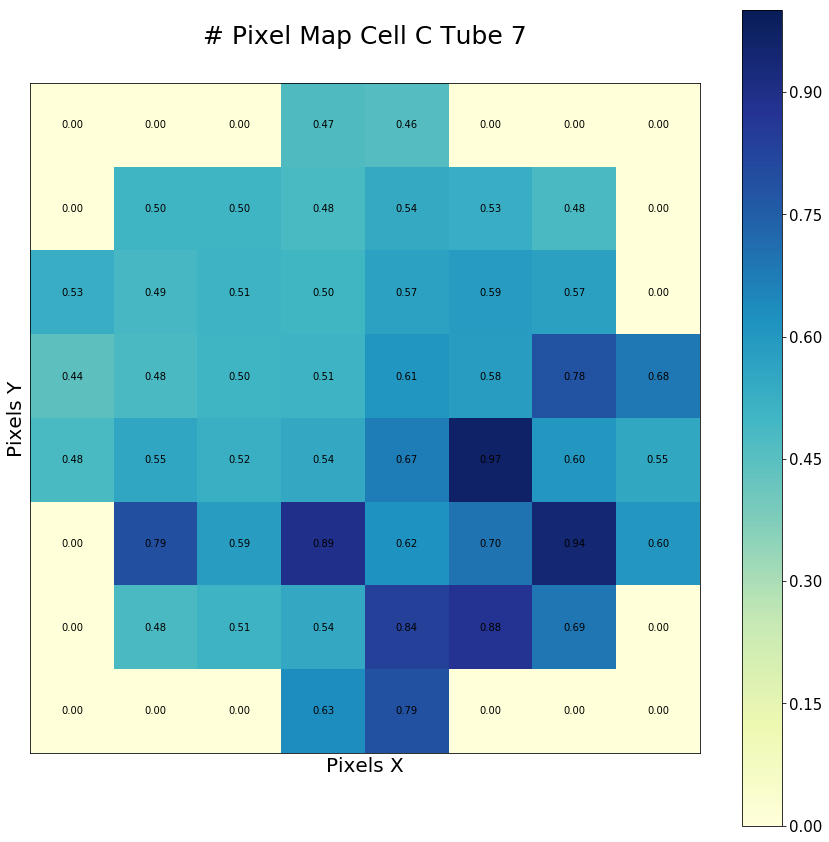

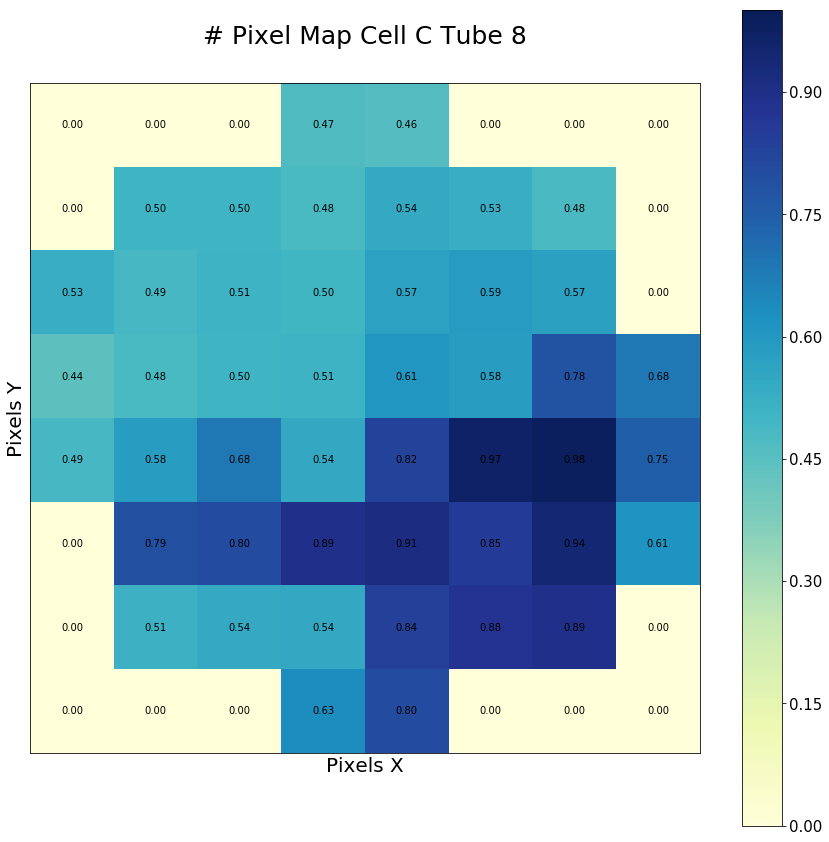

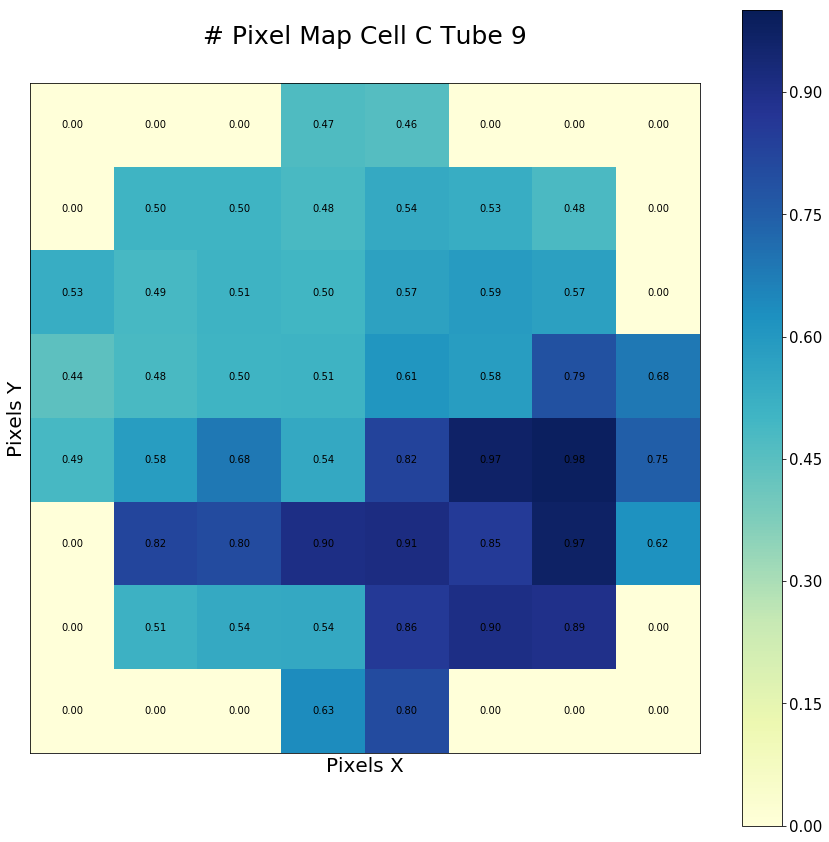

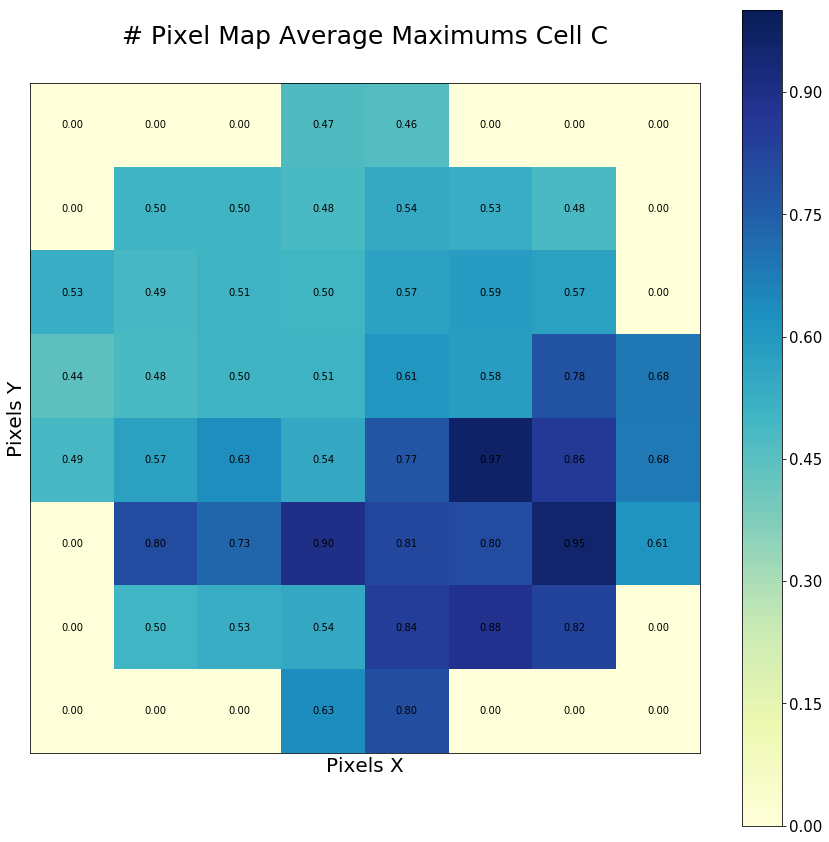

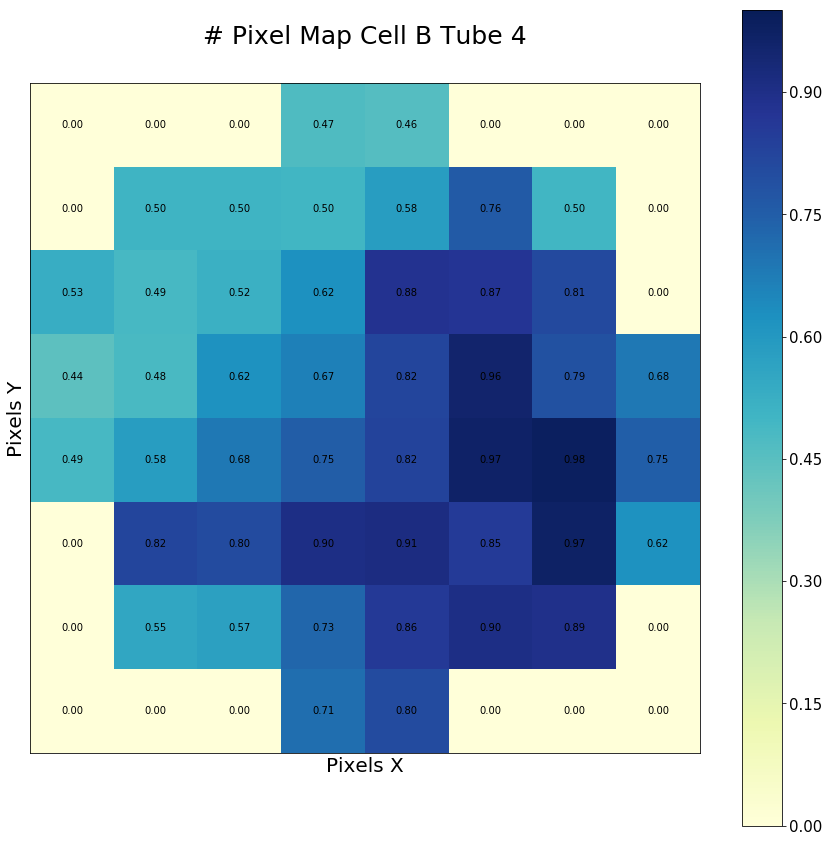

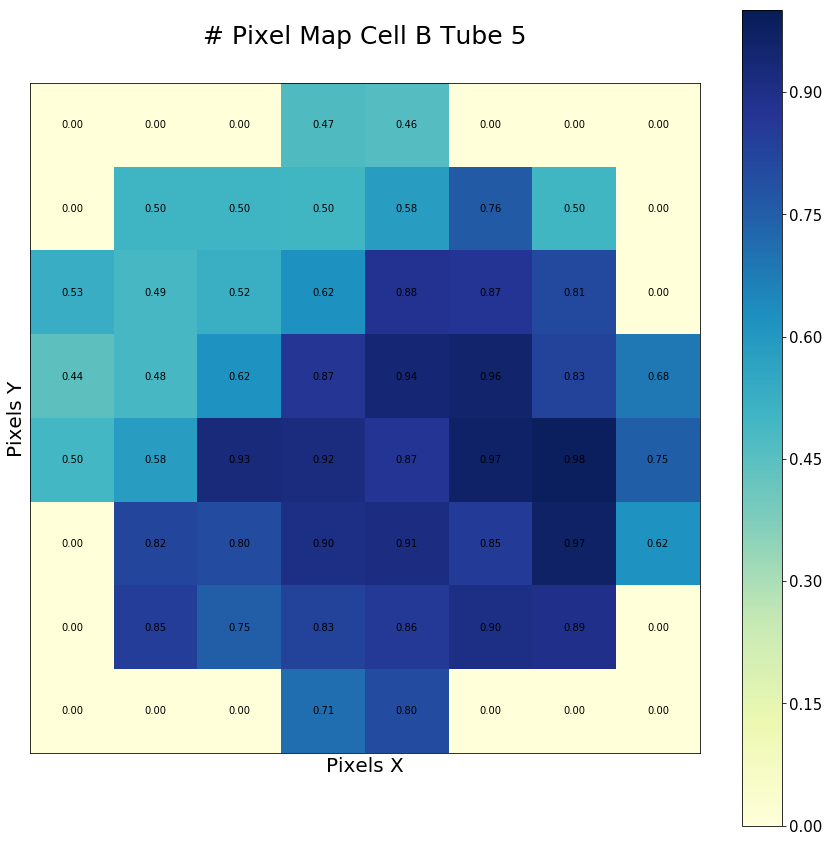

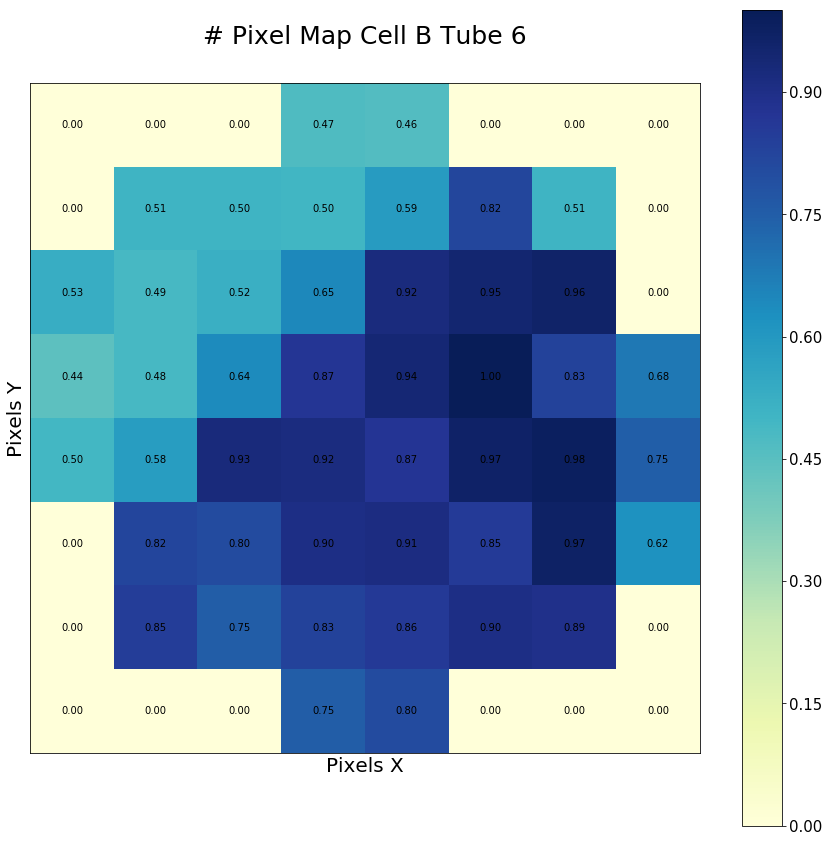

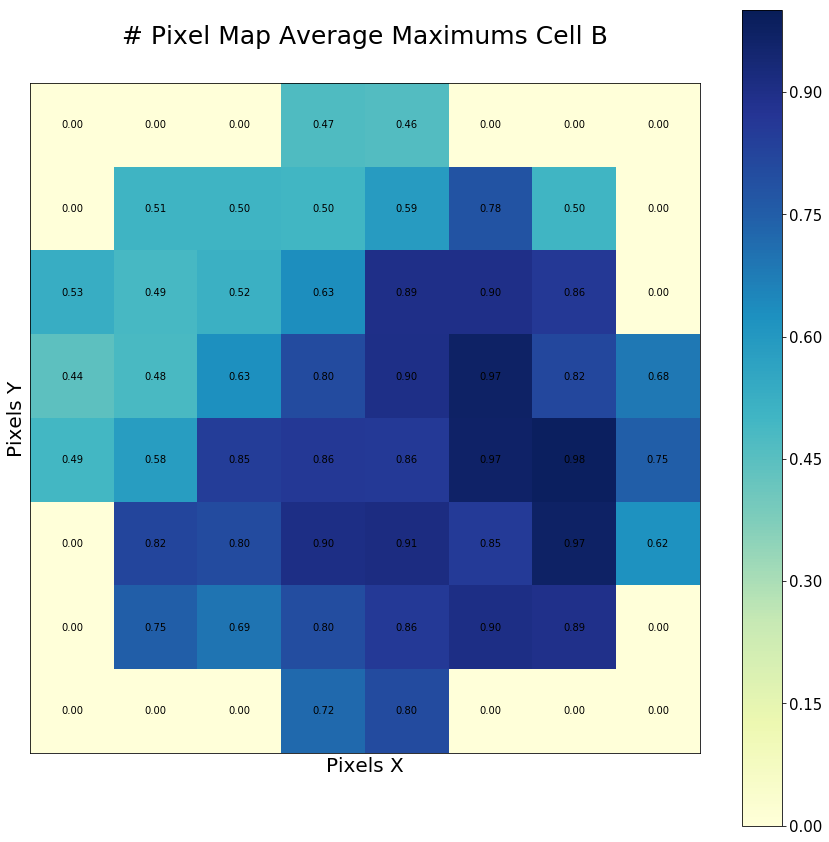

In [32]:
plot_max_value(results,input_name_json,min_max_value)

In [33]:
def plot_mean_global(results,name_json,med_value):
    
    
    
    lista = np.zeros(shape=(8,8))
    split = name_json.split('.')
    run_number = split[1][2:7]  
    
    cells_name = results.keys()
    median = np.zeros(shape=(8,8))
    
    for name in cells_name:
        
        media = np.zeros(shape=(8,8))
        contador = 0
        

        path= home_path+'BC1/analysis/CS'+run_number+'F/separate_cells_BC/'+name
        
        for n_tubes in range(3):
        
            for l in range(results[name]["tensor"][n_tubes].shape[2]):
                media += results[name]["tensor"][n_tubes][:,:,l]
                
            contador += results[name]["tensor"][n_tubes].shape[2]
    

  
        media = media/contador
        media2= (media - med_value[0])/(med_value[1]-med_value[0])

        median = np.dstack((median, media2))
        
#####################################################################################################        
        #Create the image global mean
        fig, ax = plt.subplots(figsize=(15,15))
        #create colorbar
        rm = plt.cm.ScalarMappable(cmap='YlGnBu',norm=plt.Normalize(vmin=0,vmax=1))
        rm._A = []
        cb=plt.colorbar(rm)
        cb.ax.tick_params(labelsize=15)
        tick_locator = ticker.MaxNLocator(nbins=8)
        cb.locator = tick_locator
        cb.update_ticks()
        im = ax.matshow(media2,cmap='YlGnBu' , vmin=0, vmax=1)
        X= str(l+1)
            
        for (i, j), z in np.ndenumerate(media2):
            ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
            
            
        #Sets image margins size
        plt.title("# Pixel Map Global Mean Cell "+ name[4], fontsize = 25)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("Pixels X",fontsize=20)
        plt.ylabel("Pixels Y",fontsize=20)

        #plt.savefig(path+'/Image_Global_Mean_Cell'+name[4]+'.png', bbox_inches='tight')
    
    return median

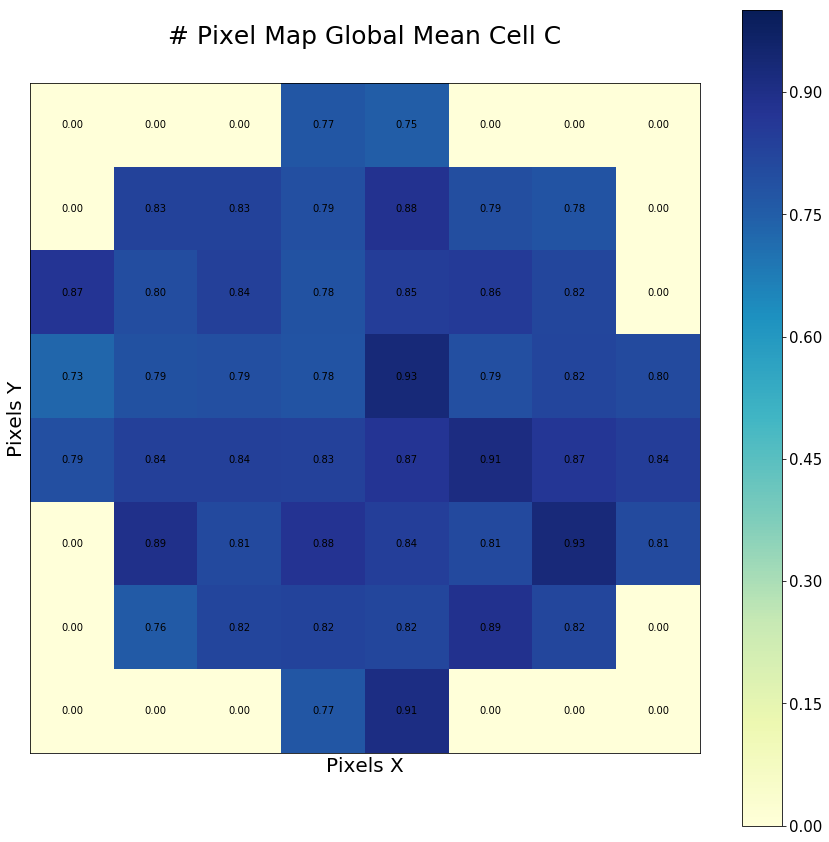

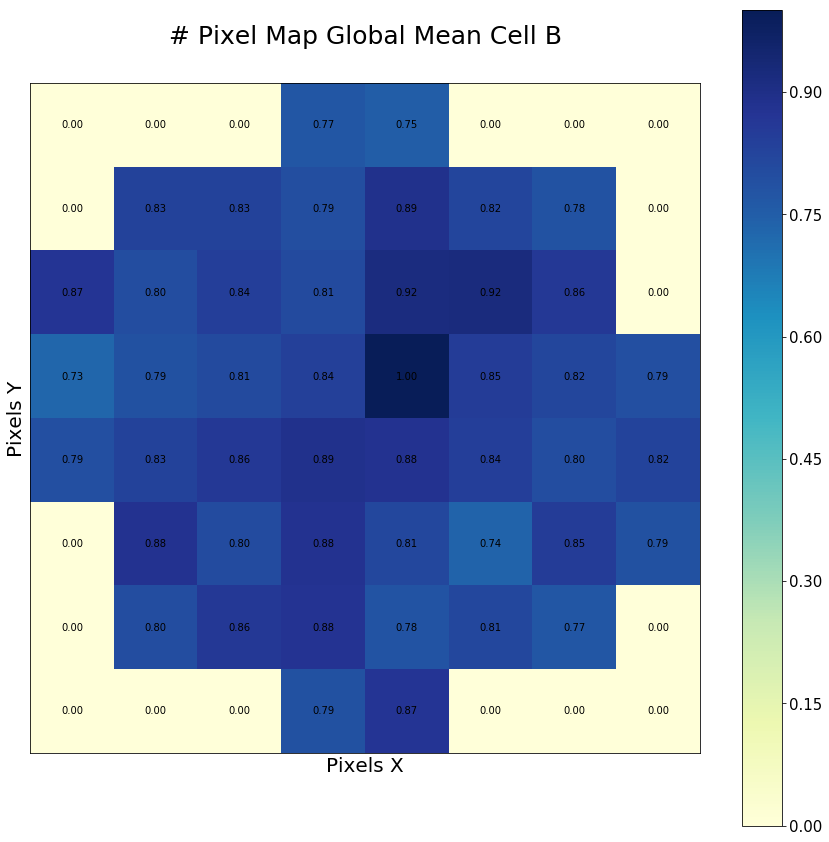

In [34]:
t=plot_mean_global(results,input_name_json,med_value)

In [35]:
path= home_path+'BC1/analysis/CS'+run_number+'F/separate_cells_BC/'

In [36]:
def compare_images(imageA, imageB , path = path):
    # compute the mean squared error and structural similarity
    # index for the images
    #m = mse(imageA, imageB)
    s = ssim(imageA, imageB, multichannel = True)

    # setup the figure
    fig = plt.figure(figsize=(25, 15))
    plt.title("# DataB vs. DataC ", fontsize = 25)
    plt.axis("off")
    #plt.suptitle("MSE: %.2f, SSIM: %.2f" % (m, s), fontsize = 15)
    plt.suptitle("SSIM: %.2f" % (s), fontsize = 15)
    
    # show first image
    fig.add_subplot(1, 2, 1)
    plt.imshow(imageA, cmap = 'YlGnBu')
    for (i, j), z in np.ndenumerate(imageA):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    plt.axis("off")
    
    # show the second image
    fig.add_subplot(1, 2, 2)
    plt.imshow(imageB, cmap = 'YlGnBu')
    for (i, j), z in np.ndenumerate(imageB):
        plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
    plt.axis("off")

    
    

    plt.savefig(path+'compare_images_ssim.png', bbox_inches='tight')
    # show the images

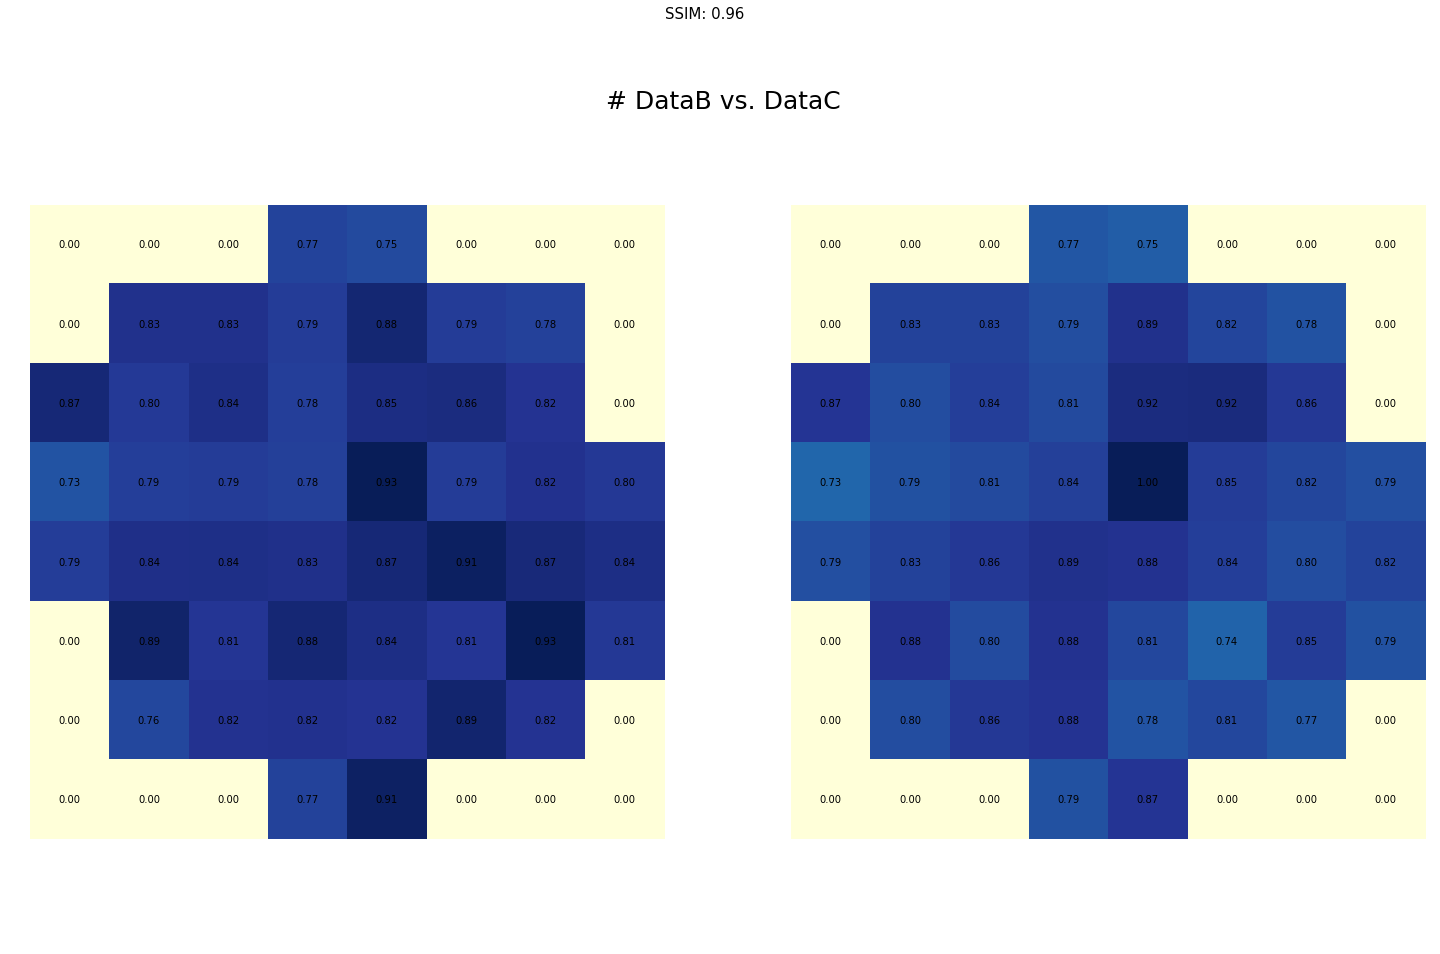

In [37]:
compare_images(t[:,:,1],t[:,:,2])

In [41]:
print np.median(t[:,:,1])
print np.median(t[:,:,2])

0.795963810663194
0.7982509911271449


In [43]:
print np.var(t[:,:,1])
print np.var(t[:,:,2])

0.13981082345683854
0.140896258601238
